# Loki Align - 2 ovarian carcinosarcoma samples
This notebook demonstrates how to run *Loki Align* on 2 adjunction sections of ovarian carcinosarcoma (OCS). It takes about 3 mins to run this notebook.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from matplotlib.colors import rgb2hex

import loki.align
import loki.preprocess
import loki.utils
import loki.plot

/opt/anaconda3/envs/loki/lib/python3.9/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


We first finetune OmiCLIP model on the target OCS sample.

In [ ]:
%%script echo "Comment this line to fine-tune the model on the OCS data."

import subprocess
import open_clip

model_name='coca_ViT-L-14'
pretrained_weight_path='./data/checkpoint.pt'
train_csv = 'visium_data/finetune_data.csv'
name = 'finetune_tnbc'

train_command = [
    'python', '-m', 'training.main',
    '--name', name,
    '--save-frequency', '5',
    '--zeroshot-frequency', '10',
    '--report-to', 'wandb',
    '--train-data', train_csv,
    '--csv-img-key', 'img_path',
    '--csv-caption-key', 'label',
    '--warmup', '10',
    '--batch-size', '64',
    '--lr', '5e-6',
    '--wd', '0.1',
    '--epochs', '10',
    '--workers', '16',
    '--model', model_name,
    '--csv-separator', ',',
    '--pretrained', pretrained_weight_path,
    '--lock-text-freeze-layer-norm',
    '--lock-image-freeze-bn-stats',
    '--coca-caption-loss-weight','0',
    '--coca-contrastive-loss-weight','1',
    '--val-frequency', '10',
    '--aug-cfg', 'color_jitter=(0.32, 0.32, 0.32, 0.08)', 'color_jitter_prob=0.5', 'gray_scale_prob=0'
]

subprocess.run(train_command)

Comment this line to fine-tune the model on the OCS data.


We provide the embeddings generated from the OmiCLIP model.
The sample data and embeddings are stored in the directory `data/loki_align/two_osc_samples`, which can be donwloaded from [Google Drive link](https://drive.google.com/file/d/1aPK1nItsOEPxTihUAKMig-vLY-DMMIce/view?usp=sharing).

Here is a list of the files that are needed to run the cell type decomposition on the pseudo Visium data:
```
    .                                                                                                                       
    ├── checkpoint_si                                                                                                 
    │   ├── 10X_Visium_gracia2021genome_HGSC_V19T26-103_C1_data_txt_features_finetune.csv                                                                              
    │   ├── 10X_Visium_gracia2021genome_HGSC_V19T26-103_D1_data_txt_features_zeroshot.csv                                                                                       
    │   ├── 10X_Visium_gracia2021genome_HGSC_V19T26-103_D1_data_img_features_zeroshot.csv     
    │   ├── 10X_Visium_gracia2021genome_HGSC_V19T26-103_D1_data_img_features_finetune.csv                                                                                           
    │   ├── 10X_Visium_gracia2021genome_HGSC_V19T26-103_C1_data_txt_features_finetune.csv                                                                     
    │   └── 10X_Visium_gracia2021genome_HGSC_V19T26-103_C1_data_txt_features_zeroshot.csv                                                                                                             
    └── visium_data                                    
        ├── 10X_Visium_gracia2021genome_HGSC_V19T26-103_D1_data.h5ad                                                                                                 
        └── 10X_Visium_gracia2021genome_HGSC_V19T26-103_C1_data.h5ad                                            
```

In [3]:
data_dir = './data/loki_align/two_osc_samples/'

In [4]:
def get_features(sample_name, feature_type, case_name):
    features_path=os.path.join(data_dir, 'checkpoint_ocs', sample_name+feature_type+case_name+'.csv')
    features = pd.read_csv(features_path, index_col=0, header = None)

    return features

In [5]:
tar_sample_name = '10X_Visium_gracia2021genome_HGSC_V19T26-103_C1_data'
ad_path = os.path.join(data_dir, 'visium_data', tar_sample_name+'.h5ad')
ad_tar, ad_tar_coor, tar_img = loki.preprocess.prepare_data_for_alignment(ad_path)

In [6]:
src_sample_name = '10X_Visium_gracia2021genome_HGSC_V19T26-103_D1_data'
ad_path = os.path.join(data_dir, 'visium_data', src_sample_name+'.h5ad')
ad_src, ad_src_coor, src_img = loki.preprocess.prepare_data_for_alignment(ad_path)

## Loki Align ST to ST
Use Loki Align to align ST to ST.

In [7]:
case_name = '_zeroshot'
feature_type = '_txt_features'
tar_features = get_features(tar_sample_name, feature_type, case_name)
src_features = get_features(src_sample_name, feature_type, case_name)

In [8]:
pca_comb_features, pca_comb_features_batch = loki.utils.get_pca_by_fit(tar_features, src_features)
pca_comb_features[:,1] = -pca_comb_features[:,1]
pca_comb_features[:,2] =  -pca_comb_features[:,2]
pca_rgb_comb = (pca_comb_features-pca_comb_features.min(axis=0))/(pca_comb_features.max(axis=0)-pca_comb_features.min(axis=0))
pca_rgb_comb[:,0] = pca_rgb_comb[:,0].max()-pca_rgb_comb[:,0]
pca_rgb_comb[:,2] = pca_rgb_comb[:,2].max()-pca_rgb_comb[:,2]
pca_rgb_comb[:,1] = pca_rgb_comb[:,1]*0.8
pca_hex_comb = [ rgb2hex(pca_rgb_comb[i,:]) for i in range(pca_rgb_comb.shape[0]) ]

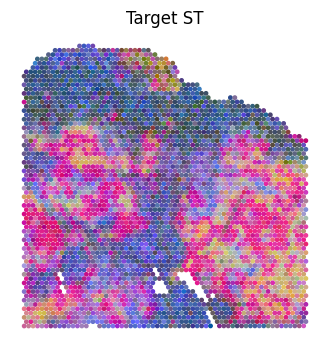

In [9]:
plt.figure(figsize=(4,4))
plt.scatter(ad_tar_coor[:,0], ad_tar_coor[:,1], marker='o', s=6, c=pca_hex_comb[:len(tar_features.T)])
plt.axis('off')
plt.title('Target ST')
plt.show()

In [10]:
cpd_coor, homo_coor, aligned_image = loki.align.align_tissue(ad_tar_coor, ad_src_coor, pca_comb_features, src_img)

In [11]:
# loki.plot.plot_alignment_with_img(ad_tar_coor, ad_src_coor, homo_coor, tar_img, src_img, aligned_image, pca_hex_comb, tar_features)

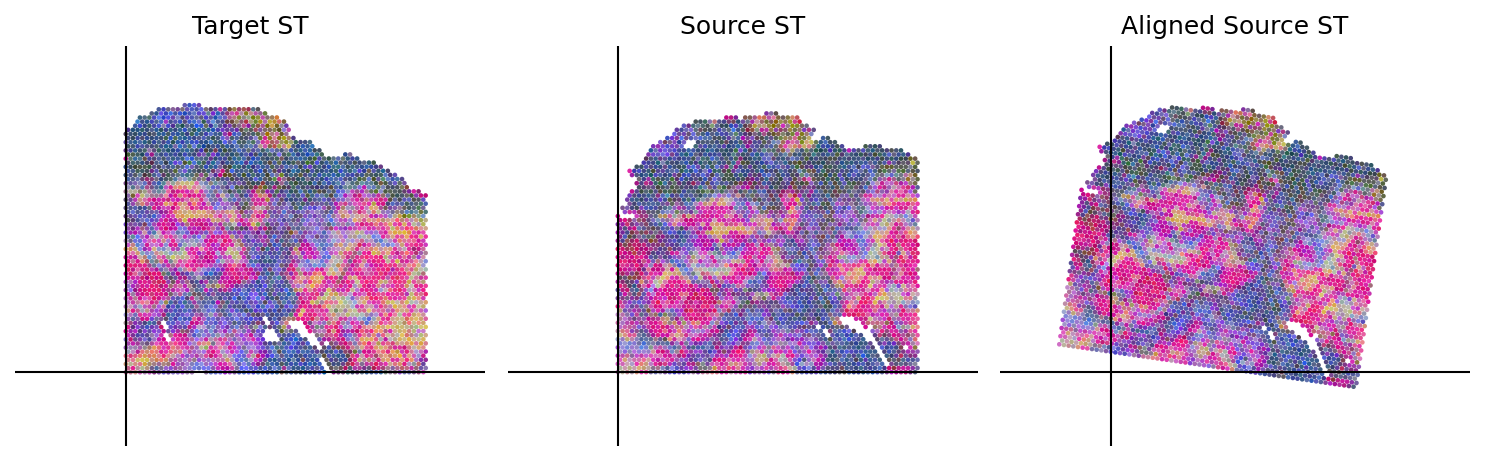

In [12]:
loki.plot.plot_alignment(ad_tar_coor, ad_src_coor, homo_coor, pca_hex_comb, tar_features, s=1.5)

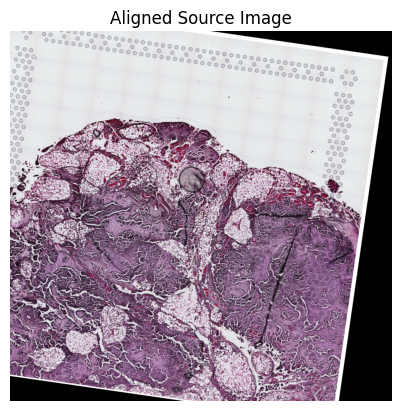

In [13]:
loki.plot.show_image(aligned_image)

## Loki Align image to ST

### Zero-shot image to ST alignment
Use zero-shot Loki Align to align image to ST.

In [14]:
case_name = '_zeroshot'
tar_features = get_features(tar_sample_name, '_txt_features', case_name)
src_features = get_features(src_sample_name, '_img_features', case_name)

In [15]:
pca_comb_features, pca_comb_features_batch = loki.utils.get_pca_by_fit(tar_features, src_features)

In [16]:
cpd_coor, homo_coor, aligned_image = loki.align.align_tissue(ad_tar_coor, ad_src_coor, pca_comb_features, src_img)

In [17]:
# loki.plot.plot_alignment_with_img(ad_tar_coor, ad_src_coor, homo_coor, tar_img, src_img, aligned_image, pca_hex_comb, tar_features)

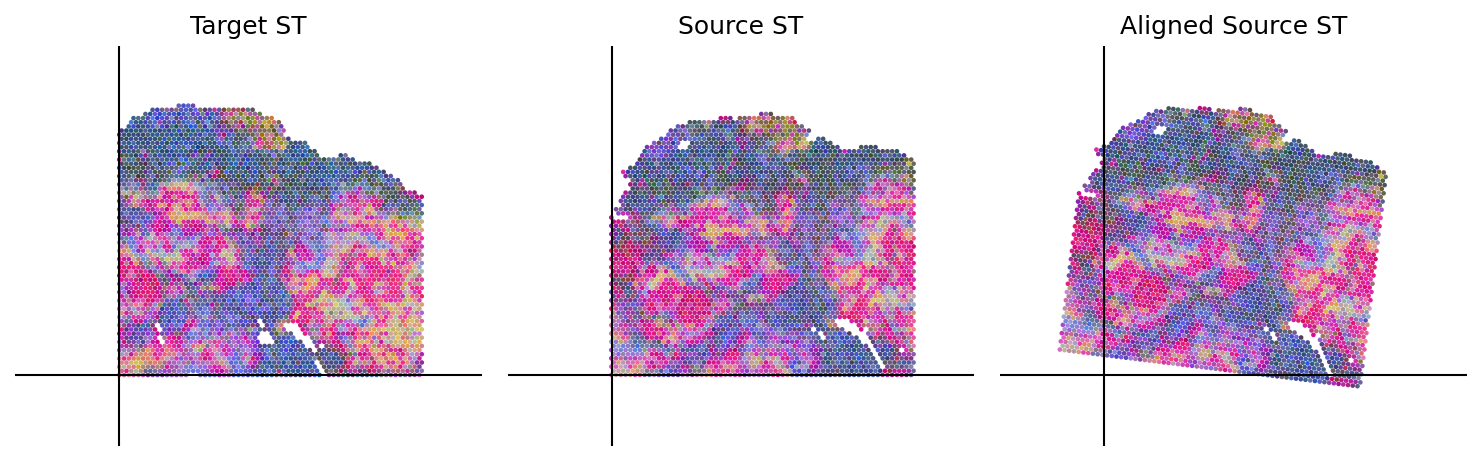

In [18]:
loki.plot.plot_alignment(ad_tar_coor, ad_src_coor, homo_coor, pca_hex_comb, tar_features, s=1.5)

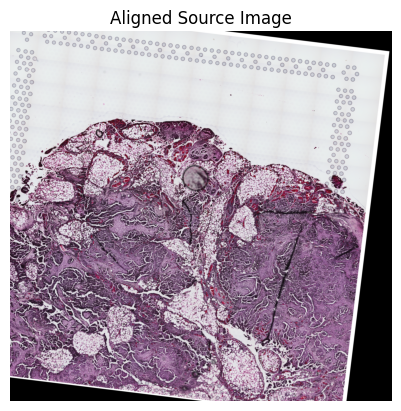

In [19]:
loki.plot.show_image(aligned_image)

### Fintuned image to ST alignment
Use Loki Align to align image to ST with finetuning.

In [20]:
case_name = '_finetune'
tar_features = get_features(tar_sample_name, '_txt_features', case_name)
src_features = get_features(src_sample_name, '_img_features', case_name)

In [21]:
pca_comb_features, pca_comb_features_batch = loki.utils.get_pca_by_fit(tar_features, src_features)

In [22]:
cpd_coor, homo_coor, aligned_image = loki.align.align_tissue(ad_tar_coor, ad_src_coor, pca_comb_features, src_img)

In [23]:
# loki.plot.plot_alignment_with_img(ad_tar_coor, ad_src_coor, homo_coor, tar_img, src_img, aligned_image, pca_hex_comb, tar_features)

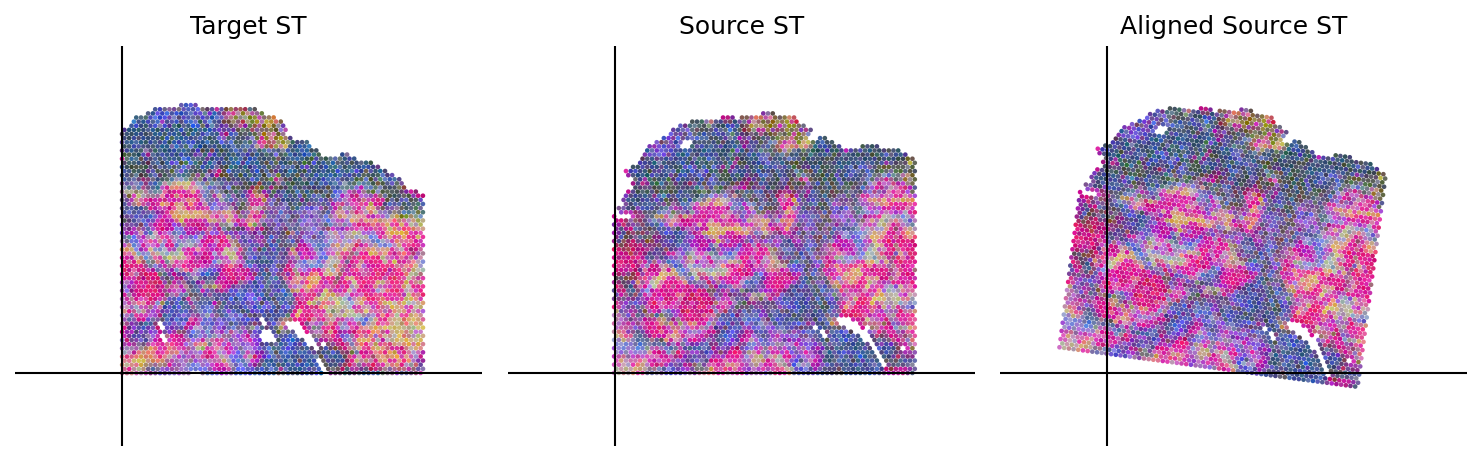

In [24]:
loki.plot.plot_alignment(ad_tar_coor, ad_src_coor, homo_coor, pca_hex_comb, tar_features, s=1.5)

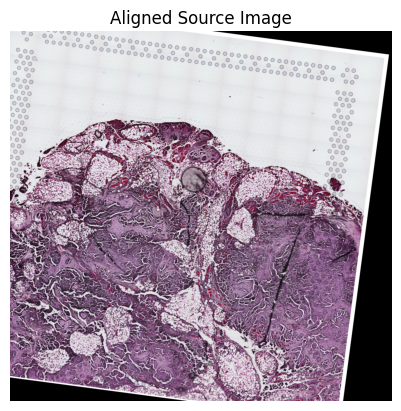

In [25]:
loki.plot.show_image(aligned_image)